In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

Q1

In [2]:
df1 = pd.read_excel("Daily_Index.xlsx", skiprows=[0, 2])
df1 = df1[df1['Index Code'] == int('000300')]
df1 = df1.drop(columns=['Index Code'])

df1['Trading Date'] = pd.to_datetime(df1['Trading Date'])
df1['Y-M'] = pd.to_datetime(df1['Trading Date']).dt.to_period('M')

df1['Closing Index'] = pd.to_numeric(df1['Closing Index'], errors='coerce')
df1['Monthly Index'] = df1.groupby('Y-M')['Closing Index'].transform('mean')

df1 = df1.drop(columns=['Trading Date', 'Closing Index'])

df1 = df1.groupby('Y-M').first().reset_index()

In [3]:
df2 = df1.copy()

df2['Prev_Monthly_Index'] = df2['Monthly Index'].shift(1)

df2['Monthly_Returns'] = df2.apply(lambda row: (row['Monthly Index'] / row['Prev_Monthly_Index'] - 1) if not pd.isnull(row['Prev_Monthly_Index']) else np.nan, axis=1)

df2 = df2.dropna(subset=['Monthly_Returns'])
df2 = df2.drop(columns=['Monthly Index', 'Prev_Monthly_Index'])

In [4]:
df3 = df2.copy()

summary_statistics = df3['Monthly_Returns'].describe()

skewness = df3['Monthly_Returns'].skew()
kurtosis = df3['Monthly_Returns'].kurt()

summary_statistics['skewness'] = skewness
summary_statistics['kurtosis'] = kurtosis

print(summary_statistics)

count       224.000000
mean          0.008022
std           0.070254
min          -0.194991
25%          -0.035406
50%           0.006210
75%           0.039084
max           0.256100
skewness      0.602406
kurtosis      2.015244
Name: Monthly_Returns, dtype: float64


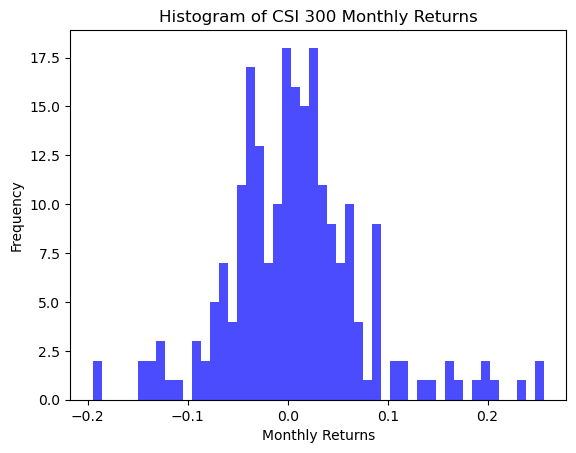

In [5]:
plt.hist(df3['Monthly_Returns'], bins=50, alpha=0.7, color='blue')

plt.title('Histogram of CSI 300 Monthly Returns')
plt.xlabel('Monthly Returns')
plt.ylabel('Frequency')

plt.show()

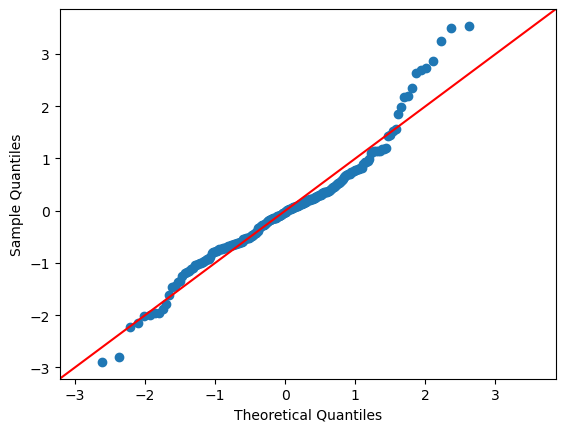

Shapiro-Wilk Test:
Statistic: 0.9551686644554138, p-value: 1.8612597614264814e-06


In [6]:
monthly_returns = df3['Monthly_Returns']

shapiro_test = stats.shapiro(monthly_returns)
sm.qqplot(monthly_returns, line ='45', fit=True)

plt.show()

print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}')

Q2

In [11]:
df4 = pd.read_excel("TRD_Week_new.xlsx", skiprows=[0, 2])
df4.columns = ['Stock Code', 'Trading Week', 'Weekly_Return', 'Market Type']
df5 = pd.read_excel("TRD_Week1_new.xlsx", skiprows=[0, 2])
df5.columns = ['Stock Code', 'Trading Week', 'Weekly_Return', 'Market Type']
df6 = pd.concat([df4, df5], ignore_index=True)

df6 = df6[~df6['Market Type'].isin([2, 8, 16, 32])]
df6 = df6.drop(columns=['Market Type'])

df6['Year-Week'] = df6['Trading Week'].str.replace('-', 'w', regex=False)
df6['Market Return'] = df6.groupby('Year-Week')['Weekly_Return'].transform('mean')

In [12]:
df7 = pd.read_excel("weekly_risk_free_rate.xlsx")

df7['trading_date_yw'] = pd.to_datetime(df7['trading_date_yw'])

df7['year'] = df7['trading_date_yw'].dt.year
df7['Trading Week'] = df7['year'].astype(str) + '-' + df7.groupby('year').cumcount().add(1).astype(str).str.zfill(2)

df7['Year-Week'] = df7['Trading Week'].str.replace('-', 'w', regex=False)

df7 = df7.drop(columns=['trading_date_yw', 'year', 'Trading Week'])

In [13]:
merged_df1 = pd.merge(df6, df7, on=['Year-Week'], how='left')

In [14]:
df8 = merged_df1.copy()

df8 = df8.dropna(subset=['risk_free_return'])

df8['rm_rf'] = df8['Market Return'] - df8['risk_free_return']
df8['ri_rf'] = df8['Weekly_Return'] - df8['risk_free_return']

df8 = df8.dropna(subset=['rm_rf', 'ri_rf'])

In [15]:
df9 = df8[df8['Trading Week'].str.contains('^2017-|2018-', regex=True)]
df9 = df9[df9['Trading Week'].str[-2:].astype(int).between(1, 52)]

In [16]:
df10 = df8[df8['Trading Week'].str.contains('^2019-|2020-', regex=True)]
df10 = df10[df10['Trading Week'].str[-2:].astype(int).between(1, 52)]

In [17]:
df11 = df8[df8['Trading Week'].str.contains('^2021-|2022-', regex=True)]
df11 = df11[df11['Trading Week'].str[-2:].astype(int).between(1, 52)]

In [18]:
df12 = df9.copy()

def regress_beta(df, stock_code):

    stock_data = df[df['Stock Code'] == stock_code]

    X = stock_data['rm_rf']
    y = stock_data['ri_rf']

    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    beta = model.params['rm_rf']
    
    return beta

betas = df12['Stock Code'].unique()
beta_values = {stock: regress_beta(df12, stock) for stock in betas}

In [19]:
df13 = pd.DataFrame(list(beta_values.items()), columns=['Stock Code', 'Beta'])

df13 = df13.dropna(subset=['Beta'])

In [20]:
merged_df2 = pd.merge(df10, df13, on=['Stock Code'], how='left')

In [21]:
def sort_by_beta(df):
    
    df.sort_values(by=['Trading Week', 'Stock Code'], inplace=True)
    
    def assign_deciles(group):
        group['Beta_Decile'] = pd.qcut(group['Beta'], 10, labels=False)
        return group

    df = df.groupby('Trading Week').apply(assign_deciles)
    
    df = df.reset_index(drop=True)

    return df

In [22]:
df14 = merged_df2.copy()

df14 = df14.drop(columns=['rm_rf', 'ri_rf'])
df14 = df14.dropna(subset=['Beta'])

df14 = sort_by_beta(df14)

In [23]:
df15 = df14.copy()

df15['Weekly Mean'] = df15.groupby(['Beta_Decile', 'Trading Week'])['Weekly_Return'].transform('mean')

df15 = df15.drop_duplicates(subset=['Year-Week', 'Beta_Decile'])

df15['rm_rf'] = df15['Market Return'] - df15['risk_free_return']
df15['rp_rf'] = df15['Weekly Mean'] - df15['risk_free_return']

In [24]:
sorted_deciles = df15['Beta_Decile'].sort_values().unique()

regression_results = {}

for decile in sorted_deciles:
    subset = df15[df15['Beta_Decile'] == decile]
    
    X = subset['rm_rf']
    y = subset['rp_rf']
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    regression_results[f'Q{decile}'] = {
        'alpha': (model.params['const'], model.pvalues['const'], model.tvalues['const']),
        'beta': (model.params['rm_rf'], model.pvalues['rm_rf'], model.tvalues['rm_rf']),
        'R_squared': model.rsquared,
        'Observations': len(subset)
    }


results_df = pd.DataFrame.from_dict(regression_results, orient='index')

results_df['alpha_value'] = results_df['alpha'].apply(lambda x: x[0])
results_df['alpha_pvalue'] = results_df['alpha'].apply(lambda x: x[1])
results_df['alpha_tvalue'] = results_df['alpha'].apply(lambda x: x[2])
results_df['beta_value'] = results_df['beta'].apply(lambda x: x[0])
results_df['beta_pvalue'] = results_df['beta'].apply(lambda x: x[1])
results_df['beta_tvalue'] = results_df['beta'].apply(lambda x: x[2])

results_df.drop(['alpha', 'beta'], axis=1, inplace=True)

results_df['alpha'] = results_df['alpha_value'].apply(lambda x: '{:.4f}'.format(x))
results_df['beta'] = results_df['beta_value'].apply(lambda x: '{:.4f}'.format(x))

column_order = ['alpha', 'alpha_pvalue', 'alpha_tvalue', 'beta', 'beta_pvalue', 'beta_tvalue', 'R_squared', 'Observations']

formatted_results = results_df[column_order]

print(formatted_results)

      alpha  alpha_pvalue  alpha_tvalue    beta    beta_pvalue  beta_tvalue  \
Q0  -0.0013      0.044508     -2.034895  0.8003   8.629534e-63    39.470423   
Q1   0.0000      0.958087      0.052686  0.8809   9.037765e-75    52.703946   
Q2   0.0002      0.663802      0.435965  0.8954   3.192636e-83    64.393658   
Q3   0.0005      0.275855      1.095670  0.9463   8.029074e-86    68.457662   
Q4  -0.0001      0.783811     -0.275094  1.0021  1.595129e-100    96.535172   
Q5   0.0000      0.989088      0.013711  1.0487   2.446896e-94    83.572940   
Q6  -0.0003      0.475663     -0.715996  1.0378   4.026829e-98    91.283832   
Q7  -0.0001      0.881969     -0.148853  1.1022   1.638296e-89    74.651843   
Q8   0.0002      0.618603      0.499388  1.0889   6.745501e-91    77.113890   
Q9  -0.0009      0.101785     -1.651443  1.1497   4.881150e-83    64.114337   

    R_squared  Observations  
Q0   0.939683           102  
Q1   0.965250           102  
Q2   0.976451           102  
Q3   0.979

In [25]:
merged_df3 = pd.merge(df11, df13, on=['Stock Code'], how='left')
merged_df3 = merged_df3.drop(columns=['rm_rf', 'ri_rf'])
merged_df3 = merged_df3.dropna(subset=['Beta'])

merged_df3 = sort_by_beta(merged_df3)

merged_df3['rp'] = merged_df3.groupby(['Beta_Decile'])['Weekly_Return'].transform('mean')

rf = merged_df3['risk_free_return'].mean()
merged_df3['rf'] = rf

merged_df3['rp_rf'] = merged_df3['rp'] - merged_df3['rf']

In [32]:
formatted_results1 = formatted_results.copy()
formatted_results1.reset_index(inplace=True)
formatted_results1.rename(columns={'index': 'Q'}, inplace=True)
formatted_results1['Beta_Decile'] = formatted_results1['Q'].str.extract('(\d+)').astype(float)
formatted_results1.drop('Q', axis=1, inplace=True)

formatted_results1

,alpha,alpha_pvalue,alpha_tvalue,beta,beta_pvalue,beta_tvalue,R_squared,Observations,Beta_Decile
0,-0.0013,0.044508,-2.034895,0.8003,8.629534e-63,39.470423,0.939683,102,0.0
1,0.0000,0.958087,0.052686,0.8809,9.037765e-75,52.703946,0.965250,102,1.0
2,0.0002,0.663802,0.435965,0.8954,3.192636e-83,64.393658,0.976451,102,2.0
3,0.0005,0.275855,1.095670,0.9463,8.029074e-86,68.457662,0.979108,102,3.0
4,-0.0001,0.783811,-0.275094,1.0021,1.595129e-100,96.535172,0.989383,102,4.0
5,0.0000,0.989088,0.013711,1.0487,2.446896e-94,83.572940,0.985885,102,5.0
6,-0.0003,0.475663,-0.715996,1.0378,4.026829e-98,91.283832,0.988141,102,6.0
7,-0.0001,0.881969,-0.148853,1.1022,1.638296e-89,74.651843,0.982372,102,7.0
8,0.0002,0.618603,0.499388,1.0889,6.745501e-91,77.113890,0.983462,102,8.0
9,-0.0009,0.101785,-1.651443,1.1497,4.881150e-83,64.114337,0.976251,102,9.0


In [27]:
merged_df4 = pd.merge(merged_df3, formatted_results1, on='Beta_Decile', how='left')

merged_df4 = merged_df4[['beta', 'Beta_Decile', 'rp_rf']]
merged_df4['beta'] = merged_df4['beta'].str.replace(r" \(.*\)", "", regex=True)

merged_df4.drop_duplicates(inplace=True)

In [28]:
df17 = merged_df4.copy()

df17['beta'] = df17['beta'].astype(float)
df17['rp_rf'] = df17['rp_rf'].astype(float)

X = df17['beta']
y = df17['rp_rf']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  rp_rf   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     5.056
Date:                Fri, 19 Apr 2024   Prob (F-statistic):             0.0547
Time:                        15:23:44   Log-Likelihood:                 65.536
No. Observations:                  10   AIC:                            -127.1
Df Residuals:                       8   BIC:                            -126.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -0.878      0.4

C:\Users\yangh\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
